# Binary-Class Tabular Model for Pumpkin Seeds Identification Using Python and XGBoost
### David Lowe
### September 19, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Pumpkin Seeds Identification dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: Pumpkin seeds are frequently consumed as confection worldwide because of their adequate amount of protein, fat, carbohydrate, and mineral contents. The research team carried out a study on the two most important types of pumpkin seed, “Ürgüp Sivrisi” and “Çerçevelik,” generally grown in Ürgüp and Karacaören regions in Turkey. Furthermore, the morphological measurements of 2500 pumpkin seeds of both varieties were captured using the gray and binary forms of threshold techniques.

ANALYSIS: The performance of the preliminary XGBoost model achieved an accuracy benchmark of 88.40%. After a series of tuning trials, the final model processed the training dataset with an accuracy score of 88.68%.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Pumpkin Seeds Dataset

Dataset ML Model: Binary classification with numerical features

Dataset Reference: https://www.muratkoklu.com/datasets/

One source of potential performance benchmarks: https://doi.org/10.1007/s10722-021-01226-0

## Task 1 - Prepare Environment

In [1]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Thu Sep 15 13:04:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Retrieve the memory configuration
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 13.6 gigabytes of available RAM



In [3]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the name for the class/label column
ORIGINAL_LABEL = 'Class'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 10

# Set default modeling scoring metric
SCORING_METRIC = 'accuracy'

# Define the directory locations and file names
TRAIN_DATASET = 'Pumpkin_Seeds_Dataset.arff'

In [7]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [8]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [9]:
dataset_path = 'https://dainesanalytics.com/datasets/muratkoklu-pumpkin-seeds-dataset/Pumpkin_Seeds_Dataset.arff'
colNames = ['Area','Perimeter','Major_Axis_Length','Minor_Axis_Length','Convex_Area',
            'Equiv_Diameter','Eccentricity','Solidity','Extent','Roundness',
            'Aspect_Ratio','Compactness','Class']
df_dataset_import = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, skiprows=24)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

    Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Convex_Area  \
0  56276    888.242           326.1485           220.2388        56831   
1  76631   1068.146           417.1932           234.2289        77280   
2  71623   1082.987           435.8328           211.0457        72663   
3  66458    992.051           381.5638           222.5322        67118   
4  66107    998.146           383.8883           220.4545        67117   

   Equiv_Diameter  Eccentricity  Solidity  Extent  Roundness  Aspect_Ratio  \
0        267.6805        0.7376    0.9902  0.7453     0.8963        1.4809   
1        312.3614        0.8275    0.9916  0.7151     0.8440        1.7811   
2        301.9822        0.8749    0.9857  0.7400     0.7674        2.0651   
3        290.8899        0.8123    0.9902  0.7396     0.8486        1.7146   
4        290.1207        0.8187    0.9850  0.6752     0.8338        1.7413   

   Compactness       Class  
0       0.8207  CERCEVELIK  
1       0.7487  CERCEVELIK  

In [10]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               2500 non-null   int64  
 1   Perimeter          2500 non-null   float64
 2   Major_Axis_Length  2500 non-null   float64
 3   Minor_Axis_Length  2500 non-null   float64
 4   Convex_Area        2500 non-null   int64  
 5   Equiv_Diameter     2500 non-null   float64
 6   Eccentricity       2500 non-null   float64
 7   Solidity           2500 non-null   float64
 8   Extent             2500 non-null   float64
 9   Roundness          2500 non-null   float64
 10  Aspect_Ratio       2500 non-null   float64
 11  Compactness        2500 non-null   float64
 12  Class              2500 non-null   object 
dtypes: float64(10), int64(2), object(1)
memory usage: 254.0+ KB


In [11]:
print(df_dataset_import.describe())

                Area    Perimeter  Major_Axis_Length  Minor_Axis_Length  \
count    2500.000000  2500.000000        2500.000000        2500.000000   
mean    80658.220800  1130.279015         456.601840         225.794921   
std     13664.510228   109.256418          56.235704          23.297245   
min     47939.000000   868.485000         320.844600         152.171800   
25%     70765.000000  1048.829750         414.957850         211.245925   
50%     79076.000000  1123.672000         449.496600         224.703100   
75%     89757.500000  1203.340500         492.737650         240.672875   
max    136574.000000  1559.450000         661.911300         305.818000   

         Convex_Area  Equiv_Diameter  Eccentricity     Solidity       Extent  \
count    2500.000000     2500.000000   2500.000000  2500.000000  2500.000000   
mean    81508.084400      319.334230      0.860879     0.989492     0.693205   
std     13764.092788       26.891920      0.045167     0.003494     0.060914   
min 

In [12]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Convex_Area          0
Equiv_Diameter       0
Eccentricity         0
Solidity             0
Extent               0
Roundness            0
Aspect_Ratio         0
Compactness          0
Class                0
dtype: int64
Total number of NaN in the dataframe:  0


In [13]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(ORIGINAL_LABEL).size())

Class
CERCEVELIK       1300
URGUP_SIVRISI    1200
dtype: int64


### 1.d) Data Cleaning

In [14]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

    Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Convex_Area  \
0  56276    888.242           326.1485           220.2388        56831   
1  76631   1068.146           417.1932           234.2289        77280   
2  71623   1082.987           435.8328           211.0457        72663   
3  66458    992.051           381.5638           222.5322        67118   
4  66107    998.146           383.8883           220.4545        67117   

   Equiv_Diameter  Eccentricity  Solidity  Extent  Roundness  Aspect_Ratio  \
0        267.6805        0.7376    0.9902  0.7453     0.8963        1.4809   
1        312.3614        0.8275    0.9916  0.7151     0.8440        1.7811   
2        301.9822        0.8749    0.9857  0.7400     0.7674        2.0651   
3        290.8899        0.8123    0.9902  0.7396     0.8486        1.7146   
4        290.1207        0.8187    0.9850  0.6752     0.8338        1.7413   

   Compactness      target  
0       0.8207  CERCEVELIK  
1       0.7487  CERCEVELIK  

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               2500 non-null   int64  
 1   Perimeter          2500 non-null   float64
 2   Major_Axis_Length  2500 non-null   float64
 3   Minor_Axis_Length  2500 non-null   float64
 4   Convex_Area        2500 non-null   int64  
 5   Equiv_Diameter     2500 non-null   float64
 6   Eccentricity       2500 non-null   float64
 7   Solidity           2500 non-null   float64
 8   Extent             2500 non-null   float64
 9   Roundness          2500 non-null   float64
 10  Aspect_Ratio       2500 non-null   float64
 11  Compactness        2500 non-null   float64
 12  target             2500 non-null   object 
dtypes: float64(10), int64(2), object(1)
memory usage: 254.0+ KB


In [16]:
print(df_dataset_import.describe())

                Area    Perimeter  Major_Axis_Length  Minor_Axis_Length  \
count    2500.000000  2500.000000        2500.000000        2500.000000   
mean    80658.220800  1130.279015         456.601840         225.794921   
std     13664.510228   109.256418          56.235704          23.297245   
min     47939.000000   868.485000         320.844600         152.171800   
25%     70765.000000  1048.829750         414.957850         211.245925   
50%     79076.000000  1123.672000         449.496600         224.703100   
75%     89757.500000  1203.340500         492.737650         240.672875   
max    136574.000000  1559.450000         661.911300         305.818000   

         Convex_Area  Equiv_Diameter  Eccentricity     Solidity       Extent  \
count    2500.000000     2500.000000   2500.000000  2500.000000  2500.000000   
mean    81508.084400      319.334230      0.860879     0.989492     0.693205   
std     13764.092788       26.891920      0.045167     0.003494     0.060914   
min 

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Convex_Area          0
Equiv_Diameter       0
Eccentricity         0
Solidity             0
Extent               0
Roundness            0
Aspect_Ratio         0
Compactness          0
target               0
dtype: int64
Total number of NaN in the dataframe:  0


In [18]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(CLASS_COLUMN).size())

target
CERCEVELIK       1300
URGUP_SIVRISI    1200
dtype: int64


### 1.e) Splitting Data into Sets

In [20]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (2500, 13) df_features_train.shape: (2500, 12) df_target_train.shape: (2500,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

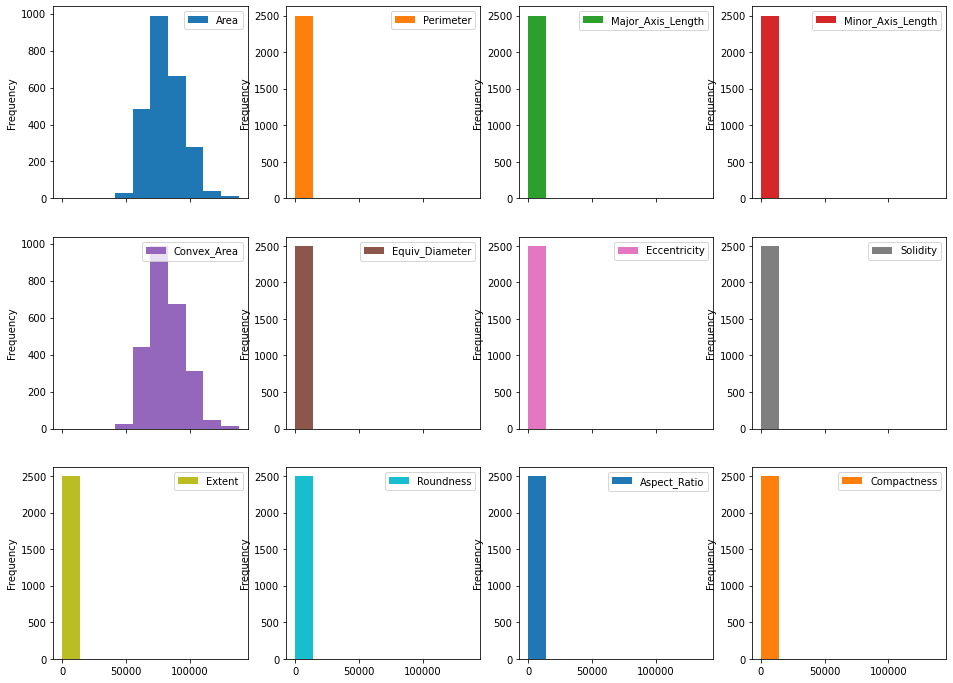

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

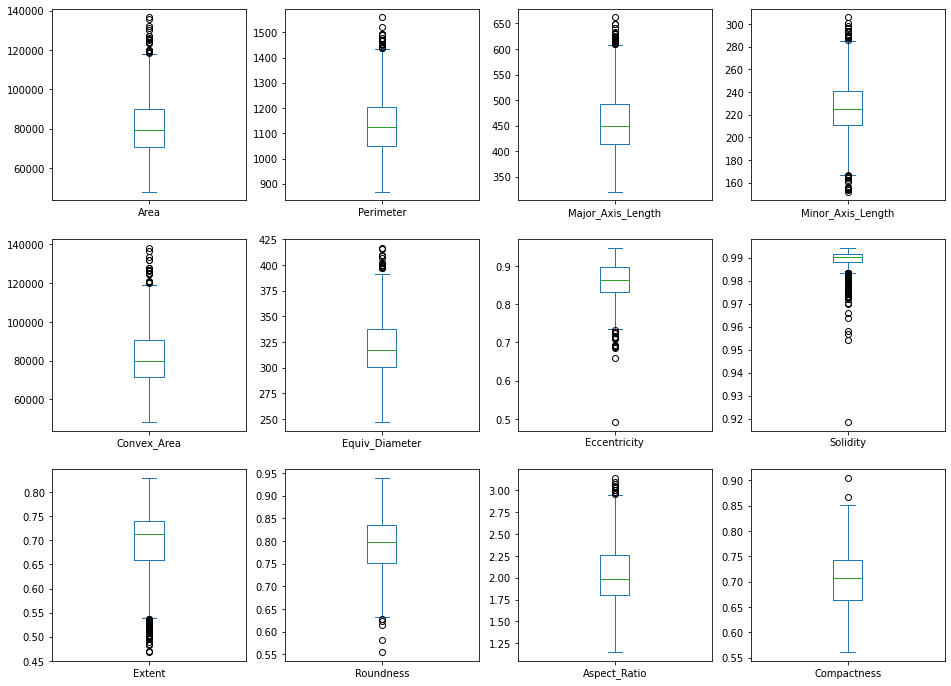

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

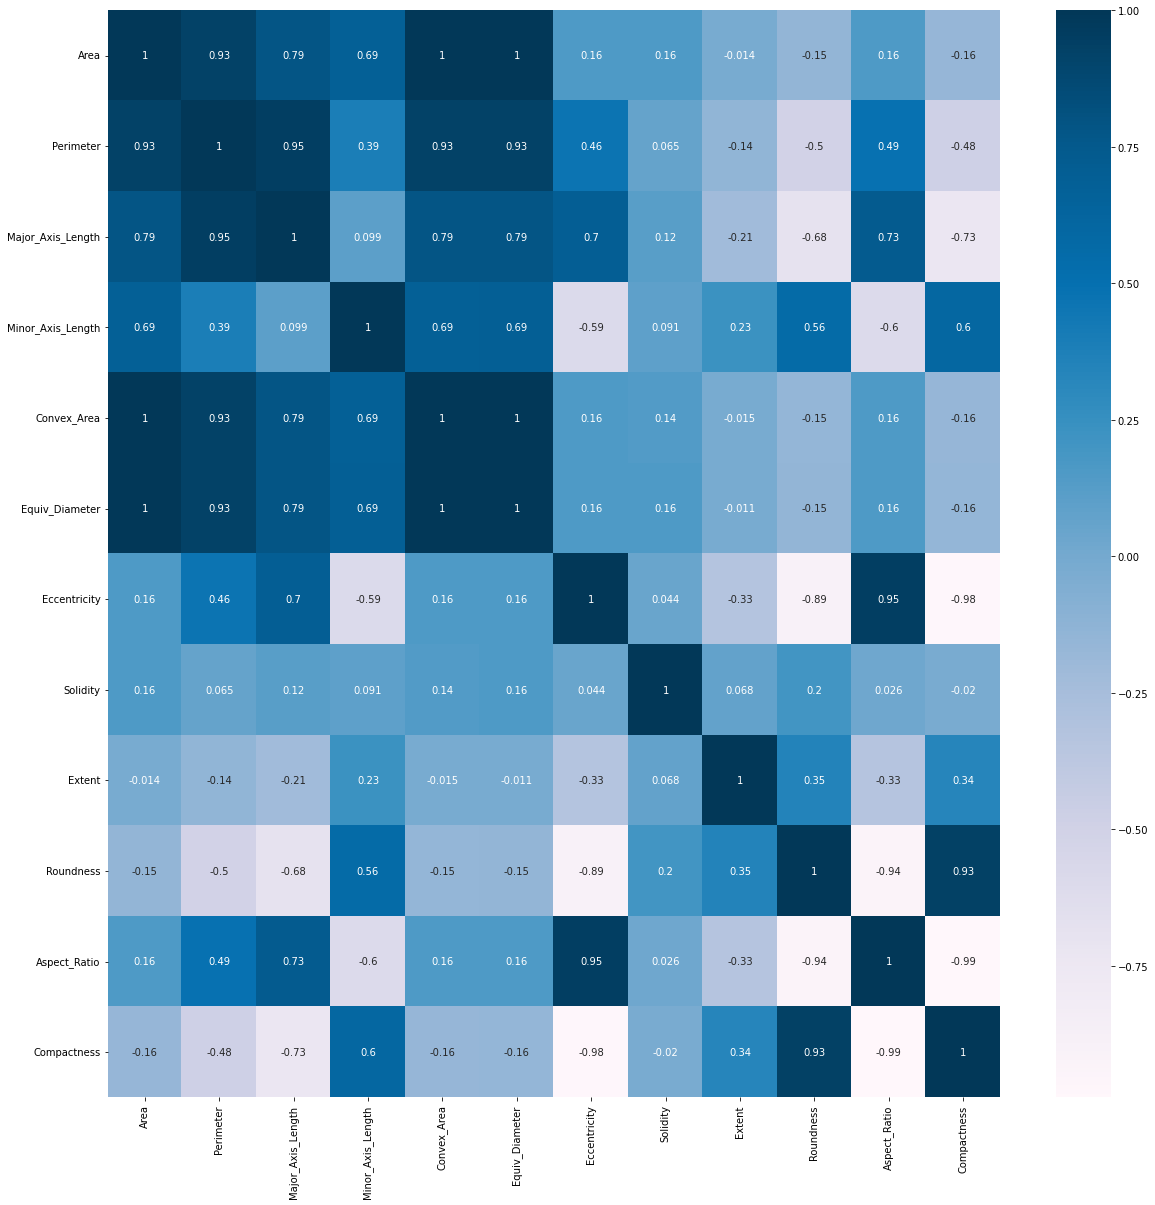

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 12
Number of categorical columns: 0
Total number of columns in the feature dataframe: 12


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (2500, 12) to array_features_train.shape: (2500, 12)


### 3.b) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training dataset for the modeling activities
array_features_train = preprocessor.fit_transform(df_features_train)
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (2500, 12) array_target_train.shape: (2500,)


In [34]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [36]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [37]:
train_models.append(('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')))

In [38]:
# Generate model in turn
for name, model in train_models:
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
    start_time_module = datetime.now()
    kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
    cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
    train_results.append(cv_results)
    train_model_names.append(name)
    train_metrics.append(cv_results.mean())
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    print(model)
    print ('Model training time:', (datetime.now() - start_time_module), '\n')
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: 0.884000 (0.015900)
XGBClassifier(eval_metric='logloss', random_state=888, tree_method='gpu_hist',
              use_label_encoder=False)
Model training time: 0:00:02.352986 

Average metrics (accuracy) from all models: 0.884
Total training time for all models: 0:00:02.381164


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished


### 4.b) Algorithm Tuning

In [39]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [40]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100, 501, 100),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([1, 2, 3]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 45 candidates, totalling 450 fits
Best: 0.885600 using {'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100}
0.884000 (0.015900) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.880000 (0.014859) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.879600 (0.013793) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.879600 (0.013793) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
0.879200 (0.015158) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.885200 (0.013862) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
0.882400 (0.017817) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
0.879200 (0.016857) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}
0.878400 (0.016512) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 400}
0.879200 (0.014945) with: {'max_depth': 3, 'min_child_weight': 2, 'n_est

In [41]:
BEST_MAX_DEPTH = grid_result1.best_params_['max_depth']
BEST_MIN_CHILD_WEIGHT = grid_result1.best_params_['min_child_weight']
BEST_N_ESTIMATORS = grid_result1.best_params_['n_estimators']
print('Best max_depth parameter:', BEST_MAX_DEPTH)
print('Best min_child_weight parameter:', BEST_MIN_CHILD_WEIGHT)
print('Best n_estimators parameter:', BEST_N_ESTIMATORS)

Best max_depth parameter: 6
Best min_child_weight parameter: 2
Best n_estimators parameter: 100


In [42]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]),
                  colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best: 0.886800 using {'colsample_bytree': 1.0, 'subsample': 0.9}
0.879600 (0.015015) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.883600 (0.015435) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.884800 (0.016473) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.882000 (0.016900) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.884400 (0.018629) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.882800 (0.013977) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.883600 (0.016824) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.882400 (0.013529) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.881200 (0.015394) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.883600 (0.013078) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.881600 (0.015513) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.882800 (0.015078) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.883200 (0.014400) with: {'cols

In [43]:
BEST_COLSAMPLE_BYTREE = grid_result2.best_params_['colsample_bytree']
BEST_SUBSAMPLE = grid_result2.best_params_['subsample']
print('Best colsample_bytree parameter:', BEST_COLSAMPLE_BYTREE)
print('Best subsample parameter:', BEST_SUBSAMPLE)

Best colsample_bytree parameter: 1.0
Best subsample parameter: 0.9


### 4.c) Compare Algorithms After Tuning

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


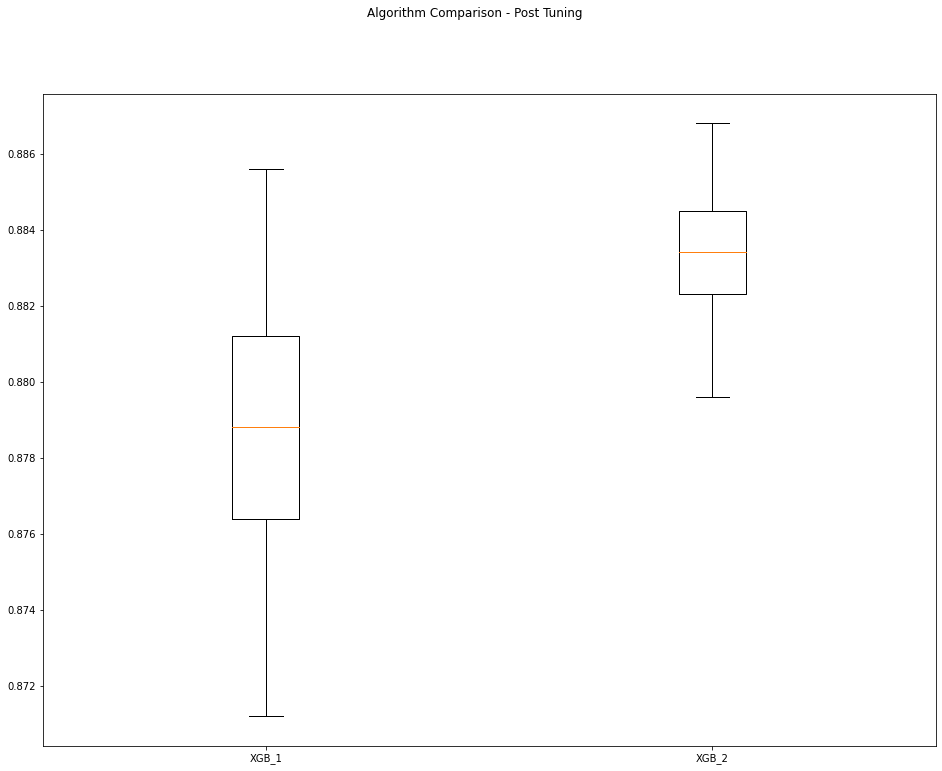

In [44]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [45]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [46]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [47]:
final_model = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            colsample_bytree=BEST_COLSAMPLE_BYTREE, subsample=BEST_SUBSAMPLE, random_state=RNG_SEED,
                            n_jobs=N_JOBS, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')
final_model.fit(array_features_train, array_target_train)
print(final_model.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 2, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 888, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.9, 'verbosity': 1, 'use_label_encoder': False, 'eval_metric': 'logloss', 'tree_method': 'gpu_hist'}


In [48]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [49]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:07:45.333941
